# CICERO SCM - model reading of input datafiles

Import some stuff

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt

Import the model

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), "../", "src"))

from ciceroscm import CICEROSCM

set up input directories

In [3]:
test_data_dir = os.path.join(os.getcwd(), "../", "tests", "test-data")

Run the model

In [4]:
# NBVAL_IGNORE_OUTPUT
scen = "test"
cscm = CICEROSCM(
    {
        "gaspam_file": os.path.join(test_data_dir, "gases_v1RCMIP.txt"),
        "emstart": 1850,
        "nystart": 1750,
        "nyend": 2100,
        "concentrations_file": os.path.join(test_data_dir, "ssp245_conc_RCMIP.txt"),
        "emissions_file": os.path.join(test_data_dir, "ssp245_em_RCMIP.txt"),
        "nat_ch4_file": os.path.join(test_data_dir, "natemis_ch4.txt"),
        "nat_n2o_file": os.path.join(test_data_dir, "natemis_n2o.txt"),
        "idtm": 24,
    }
)

In [5]:
# NBVAL_IGNORE_OUTPUT

cscm._run(
    {"results_as_dict": True},
    pamset_udm={
        "threstemp": 7.0,  # scales vertical velocity as a function of mixed layer temperature
        "rlamdo": 16.0,  # air-sea heat exchange coefficient (wm^-2K^-1)
        "akapa": 0.634,  # vertical heat diffusivity
        "cpi": 0.4,  # temperature change ratio: polar to nonpolar region
        "W": 4,  # vertical velocity (m/yr)
        "beto": 3.5,  # ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
        "lambda": 0.54,
        "mixed": 60.0,  # mixed layer depth
        "foan": 0.61,  # fraction of northern hemisphere covered by ocean
        "foas": 0.81,  # fraction of northern hemisphere covered by ocean
        "ebbeta": 0.0,  # atmospheric interhemispheric heat exchange
        "fnso": 0.7531,  # ocean area ratio, northern to southern hemisphere
        "lm": 40,  # number of vertical layers
        "ldtime": 12,
    },
    pamset_emiconc={
        "lamb": 0.8,
        "qbmb": 0.03,
        "qo3": 0.4,
        "qdirso2": -0.457,
        "qindso2": -0.514,
        "qbc": 0.2,
        "qh2o_ch4": 0.171,
        "qoc": -0.103,
        "ref_yr": 2010,
        "idtm": 24,
    },
)

# Read model output into Pandas dataframes

What output do we have?

In [6]:
cscm.results.keys()

dict_keys(['RIB_glob', 'RIB_N', 'RIB_S', 'dT_glob', 'dT_NH', 'dT_SH', 'dT_glob_air', 'dT_NH_air', 'dT_SH_air', 'dT_glob_sea', 'dT_NH_sea', 'dT_SHsea', 'OHC700', 'OHCTOT', 'Total_forcing', 'Solar_forcing', 'Volcanic_forcing_NH', 'Volcanic_forcing_SH', 'emissions', 'concentrations', 'forcing'])

Convert the results into a dataframe

In [7]:
def to_df(cscm):
    out = pd.concat(
        [pd.DataFrame(v) for k, v in cscm.results.items()],
        axis=1,
        keys=list(cscm.results.keys()),
    )
    return out

In [8]:
df_temp = to_df(cscm)

In [9]:
# NBVAL_IGNORE_OUTPUT
df_temp.head()

RIB_glob     RIB_N     RIB_S   dT_glob     dT_NH     dT_SH dT_glob_air  \
          0         0         0         0         0         0           0   
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   
1  0.022640  0.032625  0.012655  0.000994  0.001551  0.000437    0.001634   
2  0.025296  0.036083  0.014508  0.003515  0.005114  0.001917    0.004744   
3  0.013388  0.018943  0.007833  0.005062  0.006864  0.003261    0.006044   
4 -0.023666 -0.034893 -0.012438  0.003796  0.004368  0.003224    0.003482   

  dT_NH_air dT_SH_air dT_glob_sea  ... forcing                                \
          0         0           0  ... HFC143a HFC227ea HFC23 HFC245fa HFC32   
0  0.000000  0.000000    0.000000  ...     NaN      NaN   NaN      NaN   NaN   
1  0.002467  0.000800    0.000658  ...     NaN      NaN   NaN      NaN   NaN   
2  0.006877  0.002612    0.002870  ...     NaN      NaN   NaN      NaN   NaN   
3  0.008282  0.003807    0.004545  ...     NaN      NaN   NaN      NaN   NaN   
4  0.003915  0.003049    0.003962  ...     NaN      NaN   NaN      NaN   NaN   

                                 
  HFC4310mee C2F6 C6F14 CF4 SF6  
0        NaN  NaN   NaN NaN NaN  
1        NaN  NaN   NaN NaN NaN  
2        NaN  NaN   NaN NaN NaN  
3        NaN  NaN   NaN NaN NaN  
4        NaN  NaN   NaN NaN NaN  

[5 rows x 138 columns]

Plot some example fields

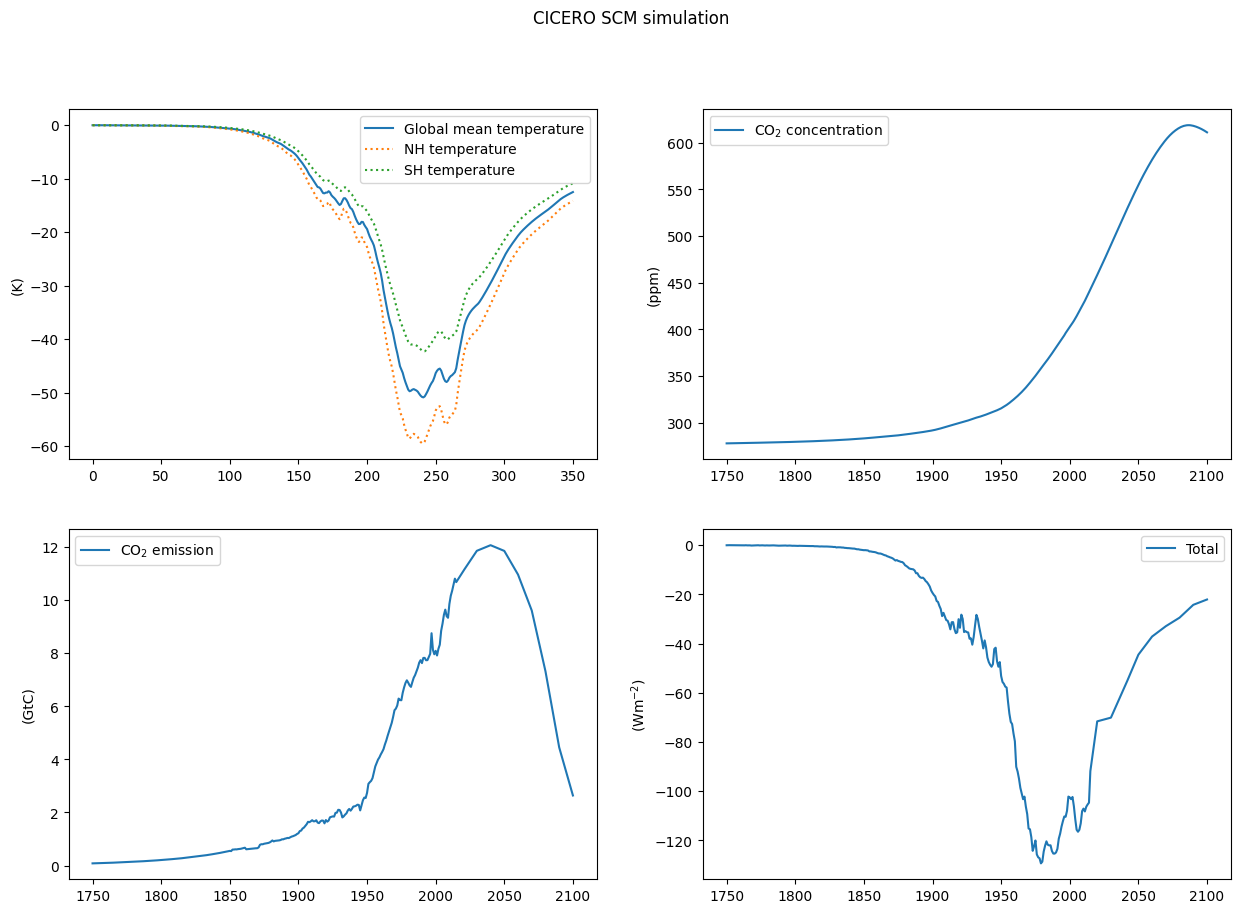

In [10]:
# NBVAL_IGNORE_OUTPUT
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axs = axs.flatten()
fig.suptitle("CICERO SCM simulation")

df_temp["dT_glob"].plot(ylabel="(K)", ax=axs[0])
df_temp["dT_NH"].plot(ylabel="(K)", ax=axs[0], linestyle=":")
df_temp["dT_SH"].plot(ylabel="(K)", ax=axs[0], linestyle=":")
axs[0].legend(["Global mean temperature", "NH temperature", "SH temperature"])

df_temp["concentrations"]["CO2"].plot(ylabel="(ppm)", ax=axs[1])
axs[1].legend([r"CO$_2$ concentration"])

df_temp["emissions"]["CO2"].plot(ylabel="(GtC)", ax=axs[2])
axs[2].legend([r"CO$_2$ emission"])

df_temp["forcing"]["Total_forcing"].plot(ylabel="(Wm$^{-2}$)", ax=axs[3])

axs[3].legend([r"Total", "CO$_2$", "CH$_4$", "Land Use"])